In [2]:
%load_ext autoreload
%autoreload 2

In [90]:
import tensorflow as tf
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import sys
sys.path.append('..')
from dataset import batcher

In [39]:
MODEL_DIR = '../saved_models/'
GRID_SEARCH_DIR = '../saved_models/grid_search_all/'
LR_RATE = 0.0001
OPT = tf.keras.optimizers.Adam(learning_rate=LR_RATE)
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

In [164]:
# Get test split
# bands = ['VIIRS']
bands = ['BLUE', 'GREEN', 'RED', 'NIR', 'SW_IR1', 'SW_IR2', 'TEMP', 'VIIRS', 'DELTA_TEMP', 'CO']
test_batcher = batcher.Batcher(bands, country_year='pollution-2018', bucket=False, shuffle=False, split='custom', repeat=1, batch_size=3511).get_dataset()
x_true = []
y_true = []
for x, y in test_batcher:
    x_true.append(x)
    y_true.append(y)

print(np.shape(x_true))

(1, 1000, 224, 224, 10)


In [165]:
# Load model
experiments = ['imagery_sample_cnn_regression_640.0001gelu']

def load_model_from_dir(model_name):
    model_path = GRID_SEARCH_DIR + model_name + '.h5'
    model = tf.keras.models.load_model(model_path, compile=False)
    
    return model

In [167]:
%%time
# Get consumption predictions
trained_model = load_model_from_dir(experiments[0])
trained_model.compile(
    loss=LOSS,
    optimizer=OPT,
    metrics=METRICS,
)

y_preds = trained_model.predict(x_true)
print(y_preds)

2023-05-30 17:37:29.063339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 5s 148ms/step
[[ 5.14728   ]
 [ 5.6053143 ]
 [ 3.2271385 ]
 [ 5.1807246 ]
 [ 3.523499  ]
 [ 3.4808192 ]
 [ 5.908898  ]
 [ 6.3343344 ]
 [ 3.2387183 ]
 [ 6.15885   ]
 [ 3.5035353 ]
 [ 3.4175134 ]
 [ 3.4026754 ]
 [ 7.1760526 ]
 [ 4.8270583 ]
 [ 6.0306487 ]
 [ 4.0383205 ]
 [-2.7784834 ]
 [ 3.3491545 ]
 [ 3.4159133 ]
 [ 4.7170143 ]
 [ 3.0365212 ]
 [ 3.7853022 ]
 [ 6.5553613 ]
 [ 2.6206827 ]
 [ 2.8192177 ]
 [ 5.2799487 ]
 [ 5.583989  ]
 [ 7.635966  ]
 [ 3.282999  ]
 [ 6.2481284 ]
 [ 3.990624  ]
 [ 4.1772237 ]
 [ 3.1098943 ]
 [ 4.1482277 ]
 [ 3.9636793 ]
 [ 4.0383205 ]
 [ 3.9082522 ]
 [ 3.8739028 ]
 [ 5.226232  ]
 [ 6.169657  ]
 [ 5.6717863 ]
 [ 5.3151975 ]
 [ 3.5477898 ]
 [-0.42483306]
 [ 4.6285186 ]
 [ 5.749344  ]
 [ 3.8061016 ]
 [ 3.554841  ]
 [ 3.4808192 ]
 [ 3.1201146 ]
 [ 3.670148  ]
 [ 5.4369226 ]
 [ 4.4403844 ]
 [ 4.012629  ]
 [ 5.778676  ]
 [ 3.3435817 ]
 [ 3.2661161 ]
 [ 5.42711   ]
 [ 6.1941977 ]
 [ 3.7069714 ]
 [ 3.990624  ]
 [ 4.321034  ]


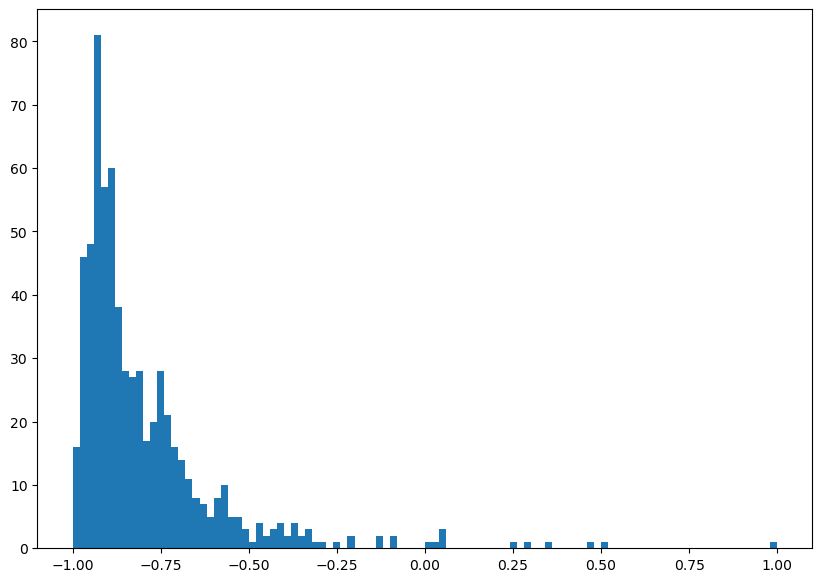

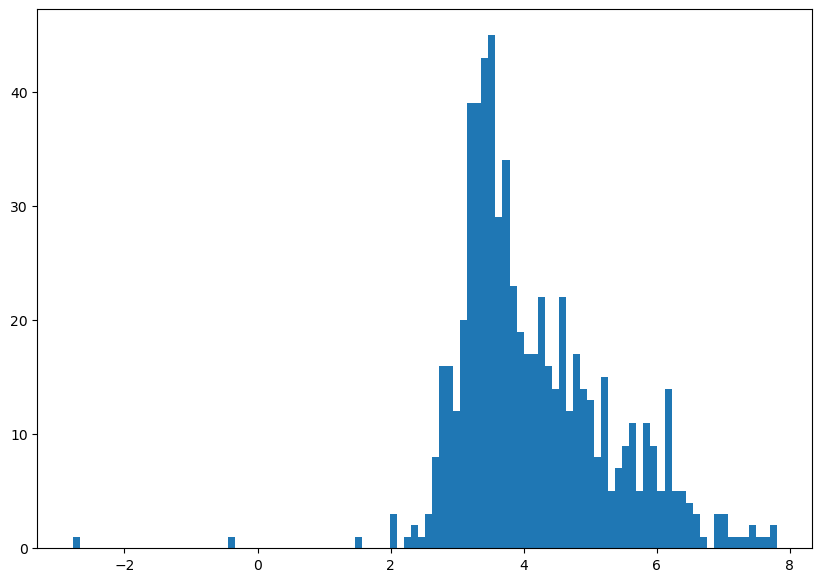

In [83]:
# Find r-squared
y_true = np.squeeze(y_true)
y_preds = np.squeeze(y_preds)

# Plot histograms
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_true, bins = 100)
plt.show()

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_preds, bins = 100)
plt.show()

y_true = 2 * ((y_true - min(y_true)) / (max(y_true) - min(y_true))) - 1
y_preds =2 * ((y_preds - min(y_preds)) / (max(y_preds) - min(y_preds))) - 1


r2 = pearsonr(y_true, y_preds)[0]

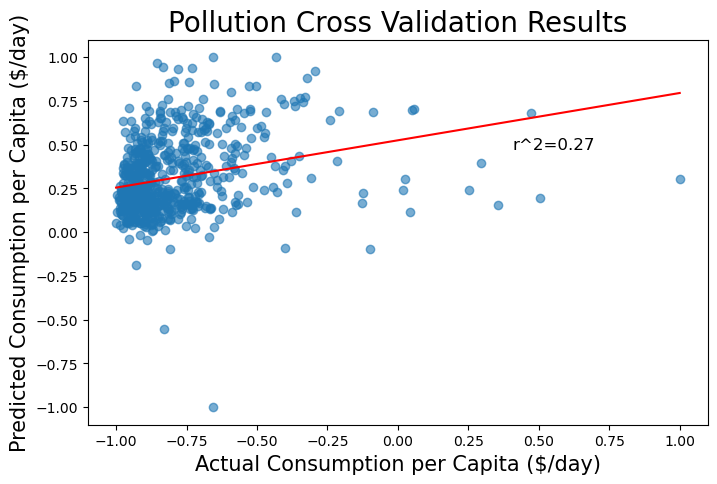

In [84]:
# Plot predictions
country = 'Pollution'
fig = plt.figure(figsize=(8,5))
plt.scatter(y_true, y_preds, alpha=0.6)
plt.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true, y_preds, 1))(np.unique(y_true)), color='red')
plt.text(0.5, 0.5, f'r^2={round(r2, 2)}', ha='left', va='top', size=12, transform=ax.transAxes)
plt.xlabel('Actual Consumption per Capita ($/day)', fontsize=15)
plt.ylabel('Predicted Consumption per Capita ($/day)', fontsize=15)
plt.title(f'{country} Cross Validation Results', fontsize=20)
# plt.xlim([np.min(y_true), 10])
# plt.ylim([np.min(y_true), 10])
plt.show()

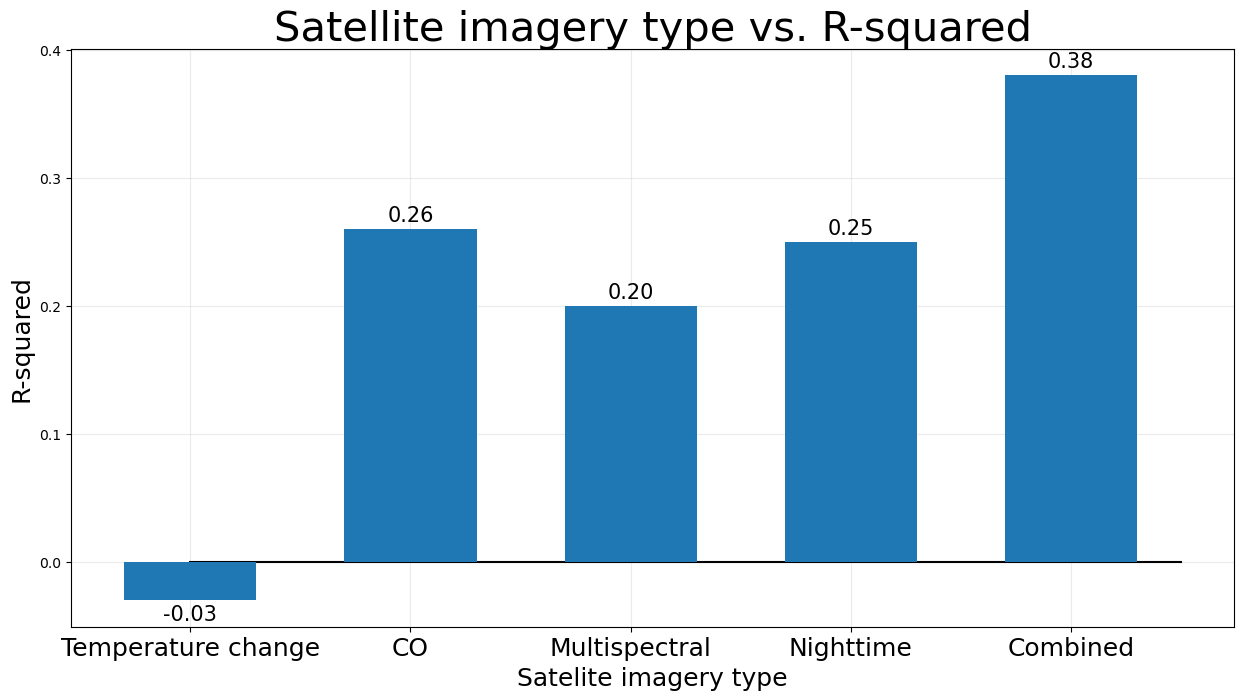

In [171]:
# Graph Bar Chart
independent_vars = ["Temperature change", "CO", "Multispectral", "Nighttime", "Combined"]
# independent_vars = ["a", "b", "c", "d", "e"]
r_squared_values = [-0.03, 0.26, 0.2, 0.25, 0.38]

fig, ax = plt.subplots(figsize=(15,7.5), dpi =100)
bar1 = ax.bar(independent_vars, r_squared_values, width=0.6, zorder=3)
plt.xticks(fontsize=18)

# Create the grid 
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

# Add label on top of each bar
ax.bar_label(bar1, labels=[f'{e:,.2f}' for e in r_squared_values], padding=3, color='black', fontsize=15) 

# Add horizontal line at y=0
# xs = np.linspace(1, 1, 4)
ax.plot([0., 4.5], [0, 0], "k-")

plt.title('Satellite imagery type vs. R-squared', fontsize=30)
plt.xlabel('Satelite imagery type', fontsize=18.0)
plt.ylabel('R-squared', fontsize=18.0)
plt.show()